# Alzheimer’s Disease Prediction by Machine Learning Models with MRI Images

### Importing Libraries

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

### Loading The Dataset

Since the dataset consists of lots of MRI images, I decided to upload them by using Kaggle API.

In [2]:
dataset_url = "https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  iremmhatipoglu


Your Kaggle Key:

  ········


100%|██████████| 28.0M/28.0M [00:01<00:00, 17.4MB/s]


### Dataset Analysis

In [3]:
#Dataset directory
dataset_dir = "./alzheimer-mri-dataset/Dataset"
print(os.listdir(dataset_dir))

files = os.listdir(dataset_dir)
print(f"Number of labels is {len(files)} in this dataset.")

['Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented']
Number of labels is 4 in this dataset.


As we can see there are four groups of images in the dataset such as 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented' and 'Non_Demented'.

In [4]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 896
Number of images in Very_Mild_Demented folder: 2240
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


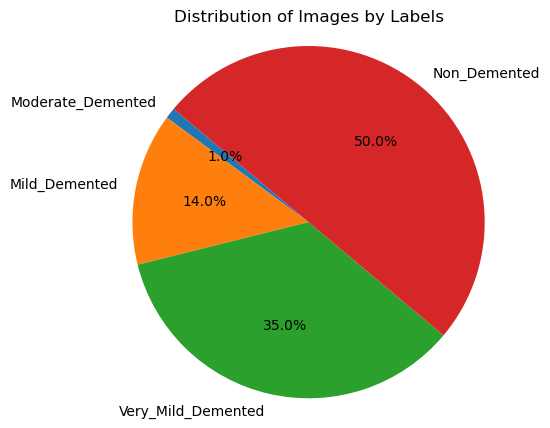

In [5]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Labels')
plt.axis('equal')
plt.show()

In [6]:
def visualise_images(path, label, num_samples= 5):
    label_dir = os.path.join(path, label)
    image_files = os.listdir(label_dir)
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(random_samples):
        img_path = os.path.join(label_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image {i+1}')
        plt.axis('off')
    plt.show()

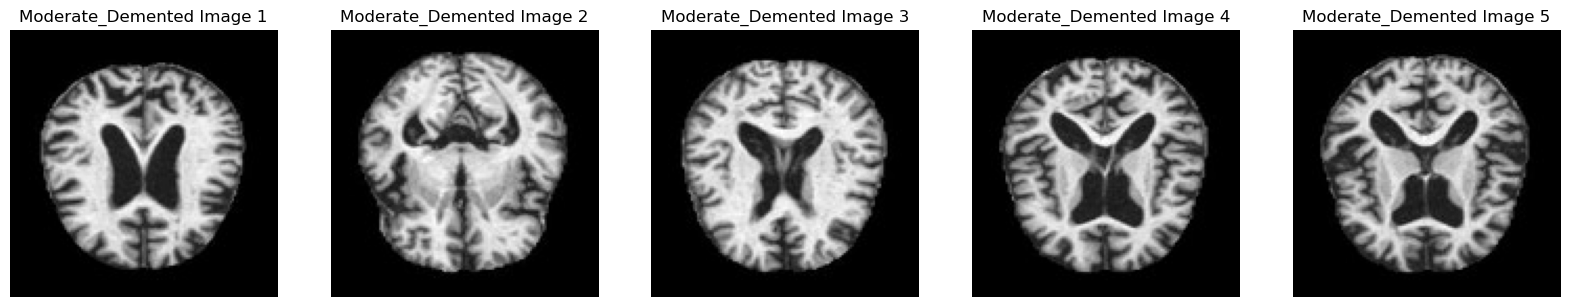

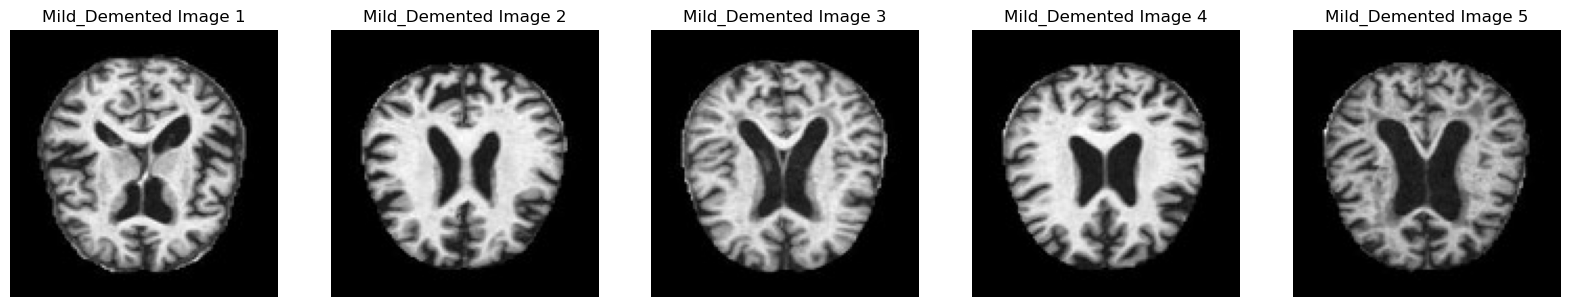

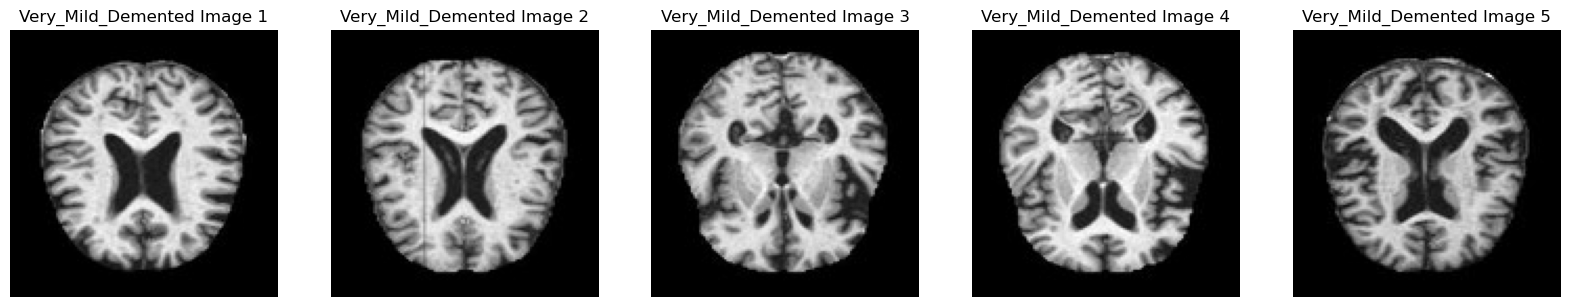

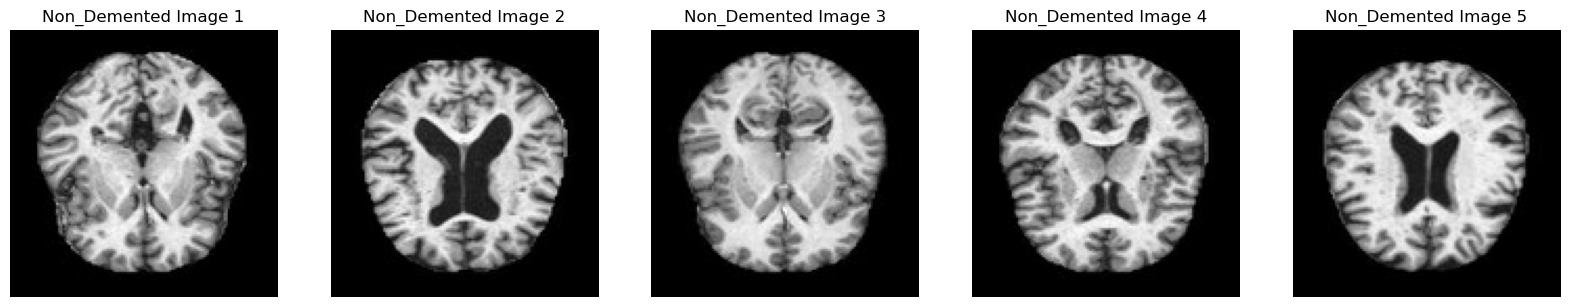

In [7]:
labels = os.listdir(dataset_dir)
for label in labels:
    visualise_images(dataset_dir, label)

### Dataset Preprocessing

#### Resize

Each image in the dataset needs to have the same size—that is, 128 × 128. Even though the images that were chosen randomly have the same size, it is still important to review the data set and make any modifications that are required.

In [8]:
def resize_images(path, label, size=(128,128)):
    label_dir = os.path.join(path, label)
    for image_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != size:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized) 

In [9]:
labels = os.listdir(dataset_dir)
for label in labels:
    resize_images(dataset_dir, label)
    if resize_images(dataset_dir, label):
        print(f"Images resized in {label}.")
    else:
        print(f"None of the images needed to be resized in {label}.")

None of the images needed to be resized in Moderate_Demented.
None of the images needed to be resized in Mild_Demented.
None of the images needed to be resized in Very_Mild_Demented.
None of the images needed to be resized in Non_Demented.


### Data Augmentation

There is a significant imbalance in the data set, as we have already analysed.  A greater number of images have been included in some labels than others. It has been decided to use the Generative Model to perform augmentation to prevent any potential problems that this situation might cause. 

#### DCGAN

In [10]:
#parameters
img_width, img_height = 128, 128
batch_size=32
latent_dim = 128
epochs = 30

In [11]:
#directories
img_generator = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)
#Main Data
dataset = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode='categorical'
)
#Moderate Data
moderate_demented = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    classes=['Moderate_Demented']
)

Found 6400 images belonging to 4 classes.
Found 64 images belonging to 1 classes.


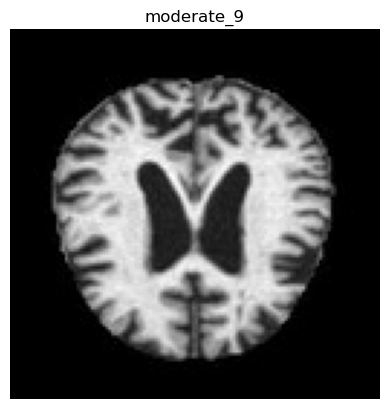

In [12]:
#Display random image from 'Moderate_Demented' class
moderate_dataset = os.path.join(dataset_dir, 'Moderate_Demented')
moderate_images = os.listdir(moderate_dataset)

img_name = np.random.choice(moderate_images)
img_path = os.path.join(moderate_dataset, img_name)

img = plt.imread(img_path)
img_name = os.path.splitext(img_name)[0]

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(img_name)
plt.show()

Found 6400 files belonging to 4 classes.


2024-04-09 20:30:27.677861: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


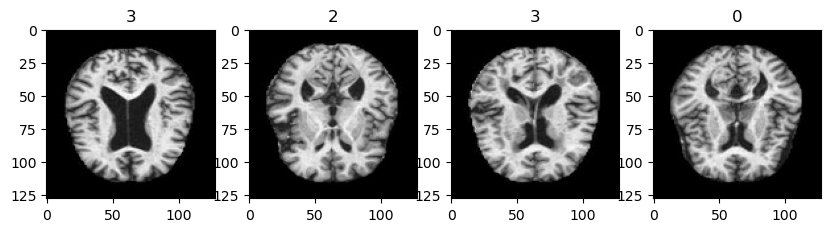

In [13]:
dataset_train = keras. utils.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = (img_width, img_height))

data_iterator = dataset_train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
train_gen = img_generator.flow_from_directory(
        dataset_dir,
        target_size = (64, 64),
        batch_size = batch_size,
        class_mode = None)

Found 6400 images belonging to 4 classes.


In [15]:
#Generator
def generator_model():
    generator = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=latent_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return generator

generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0

In [16]:
#Discriminator
def discriminator_model():
    discriminator = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return discriminator

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)            

In [17]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

        # loss metrics
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')


    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    
        generated_images = self.generator(random_latent_vectors)
    
        combined_images = tf.concat([generated_images, real_images], axis=0)
    
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))  # Adding noise to labels

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": d_loss, "g_loss": g_loss}


In [18]:
#Monitor and saving images
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128, num_images=10, output_dir='./alzheimer-mri-dataset/Dataset/Moderate_Demented'):
        self.latent_dim = latent_dim
        self.num_images = num_images
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_images, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_images):
            img = keras.utils.array_to_img(generated_images[i])
            img_path = os.path.join(self.output_dir, f"generated_img_{epoch:03d}_{i}.png")
            img.save(img_path)

In [19]:
dcgan_monitor = DCGANMonitor(output_dir='./alzheimer-mri-dataset/Dataset/Moderate_Demented')

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = latent_dim)
dcgan.compile(g_optimizer = Adam (learning_rate= 0.0001, beta_1= 0.0001), d_optimizer= Adam (learning_rate = 0.0001 , beta_1= 0.0001), loss_fn = BinaryCrossentropy())

# fit the model and save the history
history = dcgan.fit(train_gen, epochs=epochs, callbacks=[DCGANMonitor()])

Epoch 1/30
200/200 [==============================] - 91s 450ms/step - d_loss: 0.3830 - g_loss: 1.3175
Epoch 2/30
200/200 [==============================] - 89s 446ms/step - d_loss: 0.4497 - g_loss: 1.3637
Epoch 3/30
200/200 [==============================] - 90s 450ms/step - d_loss: 0.6254 - g_loss: 0.9765
Epoch 4/30
200/200 [==============================] - 93s 464ms/step - d_loss: 0.6928 - g_loss: 0.7913
Epoch 5/30
200/200 [==============================] - 96s 478ms/step - d_loss: 0.6636 - g_loss: 0.8029
Epoch 6/30
200/200 [==============================] - 93s 466ms/step - d_loss: 0.6706 - g_loss: 0.7962
Epoch 7/30
200/200 [==============================] - 101s 503ms/step - d_loss: 0.6732 - g_loss: 0.7874
Epoch 8/30
200/200 [==============================] - 93s 466ms/step - d_loss: 0.6760 - g_loss: 0.7851
Epoch 9/30
200/200 [==============================] - 92s 458ms/step - d_loss: 0.6740 - g_loss: 0.7840
Epoch 10/30
200/200 [==============================] - 92s 459ms/step - 

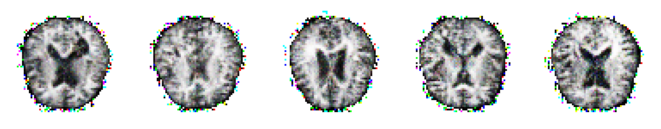

In [20]:
plt.figure(figsize=(10, 10))

for i in range(5):
    plt.subplot(6, 6, i + 1)
    noise = tf.random.normal([1, 128])
    mg = dcgan.generator(noise)
    
    #denormalize
    mg = (mg * 255) + 255
    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()

After successfully finishing the data augmentation stage, we chose to randomly choose a number of images loaded with data folders to balance the distribution of labels in the dataset.

In [27]:
#To balance the dataset deleting the images from some folders
def delete_images(label_dir, num_images):
    # List all images in the directory
    images = os.listdir(label_dir)
    
    # Check if the number of images to delete is greater than the total number of images
    num_images = min(num_images, len(images))
    
    # Randomly select images to delete
    images_to_delete = random.sample(images, num_images)
    
    # Delete the selected images
    for image in images_to_delete:
        image_path = os.path.join(label_dir, image)
        os.remove(image_path)

non_demented_dir = os.path.join(dataset_dir, "Non_Demented")
very_mild_demented_dir = os.path.join(dataset_dir, "Very_Mild_Demented")

num_delete_nd = 2000
num_delete_vmd = 1000
delete_images(non_demented_dir, num_delete_nd)
delete_images(very_mild_demented_dir, num_delete_vmd)

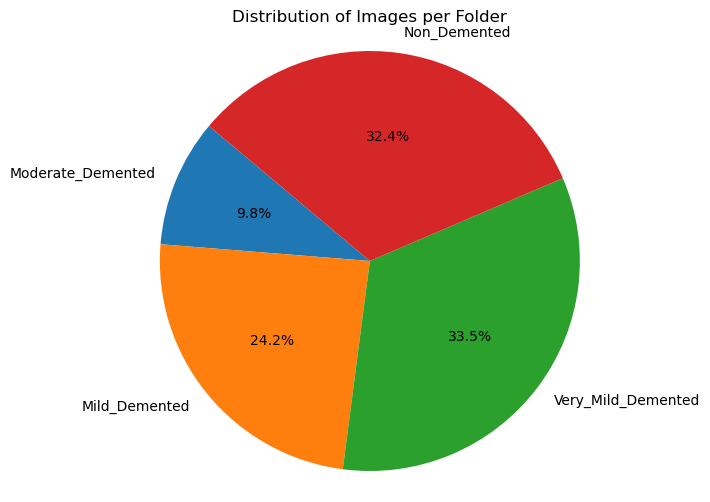

Number of Images in Each Folder:
Moderate_Demented: 364 images
Mild_Demented: 896 images
Very_Mild_Demented: 1240 images
Non_Demented: 1200 images


In [28]:
folders = os.listdir(dataset_dir)
folder_image_count = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        folder_image_count[folder] = len(images)

#distribution using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(folder_image_count.values(), labels=folder_image_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Folder')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#numbers of images in each folder
print("Number of Images in Each Folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

As we can see in the piechart, the dataset is not more balanced and ready to be worked with.